# III. Modeling

### In this last notebook I do some more feature engineering then develop and tune the model.

In [1]:
import pandas as pd
import pickle
from mvp_functions.functions import *

df = pd.read_pickle('df.pkl')

In [2]:
#Define feature df
X = df.drop(columns=['MVP', 'PLAYER_ID'], axis=1)

#Custom function that checks for multicollinearity and drops features with Pearson correlation coefficient >= 0.8
drop_corr(X)

#Split into training and test set
y_train = df.loc[(df['SEASON_ID']>=2000)&(df['SEASON_ID']<2015),:]['MVP']
y_test = df.loc[(df['SEASON_ID']>=2015),:]['MVP']
X_train = X.loc[(X['SEASON_ID']>=2000)&(X['SEASON_ID']<2015),:]
X_test = X.loc[(X['SEASON_ID']>=2015),:]

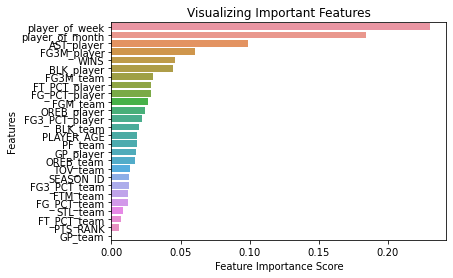

In [3]:
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

#Custom function that fits the RFC and plots important features
rf = RandomForestClassifier(random_state=42)
plot_importances(X_train, y_train, rf)

### From the plot above, the five most important features, in order are: of player of the weeks, of player of the months, player assists, 3-point FGs made, wins. 

### Bear in mind that random forests will give outsized importance to features with multiple categories, and correlated features will have lower importance than they would otherwise.

### Now it is time to build and tune the model. I use GridSearch to tune the hyperparameters and ROC-AUC as the scoring metric as it offers the best performance for class imbalance problems.

In [4]:
#Tune the RandomForestClassifier hyperparameters
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

rfc = RandomForestClassifier(random_state=42)
params = {
    'n_estimators':[100, 250, 500],
    'criterion':['gini', 'entropy'],
    'max_features':['auto', 'sqrt', 'log2'],
    'max_depth':[None, 5, 10]
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
search = GridSearchCV(estimator=rfc, scoring='roc_auc', cv=cv, param_grid=params, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
search.best_params_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 500}

In [5]:
from sklearn.metrics import roc_auc_score as ROC

model = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=None, max_features='auto', n_estimators=500)
model.fit(X_train, y_train)

#Get prediction probabilities and convert the result to dataframe
y_pred_prob = model.predict_proba(X_test)
pred_df = pd.DataFrame(y_pred_prob)[[1]].rename(columns={1:'PRED_PROB'})
#Concatenate the probabilities with df
test = df.loc[(df['SEASON_ID']>=2015),:].reset_index(drop=True)
df_ = pd.concat([pred_df, test], axis=1)

In [9]:
predictions = []
# Custom function that converts predictions to binary true/false and returns results dataframe
results = calc_results(df_, predictions)
results.to_csv('results.csv')

results

,SEASON_ID,DISPLAY_FIRST_LAST,PREDICTIONS,MVP
0,2015,Stephen Curry,1,1
1,2016,Russell Westbrook,0,1
2,2016,Stephen Curry,1,0
3,2017,James Harden,0,1
4,2017,DeMar DeRozan,1,0
5,2018,Giannis Antetokounmpo,1,1
6,2019,Giannis Antetokounmpo,1,1
7,2020,Nikola Jokic,1,1


In [7]:
#Compute K-fold cross-validation ROC-AUC score
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
ROC_CV = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

print('-ROC_AUC SCORE-')
print('CV ROC_AUC: {:.3f}'.format(ROC_CV.mean()))
print('Test ROC_AUC {:.3f}'.format(ROC(y_test, predictions)))

-ROC_AUC SCORE-
CV ROC_AUC: 0.997
Test ROC_AUC 0.833


In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[3506,    2],
       [   2,    4]])

# Results & Summary:
### I used the years 2000-2014 to train the model and the years 2015-2020 to test it. For the 6 years 2015-2020, my model correctly predicted the MVP 4 times, for a ROC-AUC score of 0.833. This score represents good discrimination for the award which is often thought of as being subjective with vague judging criteria. These results indicate that Random Forest Classification is a valid method for predicting the MVP. It should be noted that the sample size is inherently small, so it is difficult to make an official judgement of the model's validity.
# Future Work:
### Since player of the week/month were the two highest most important features of the model, it may be interesting to break down the important features for winning those awards and incorporate those into the MVP model. 